In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e23/sample_submission.csv
/kaggle/input/playground-series-s3e23/train.csv
/kaggle/input/playground-series-s3e23/test.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e23/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s3e23/test.csv")

# Plotting Data to look at distribution of features

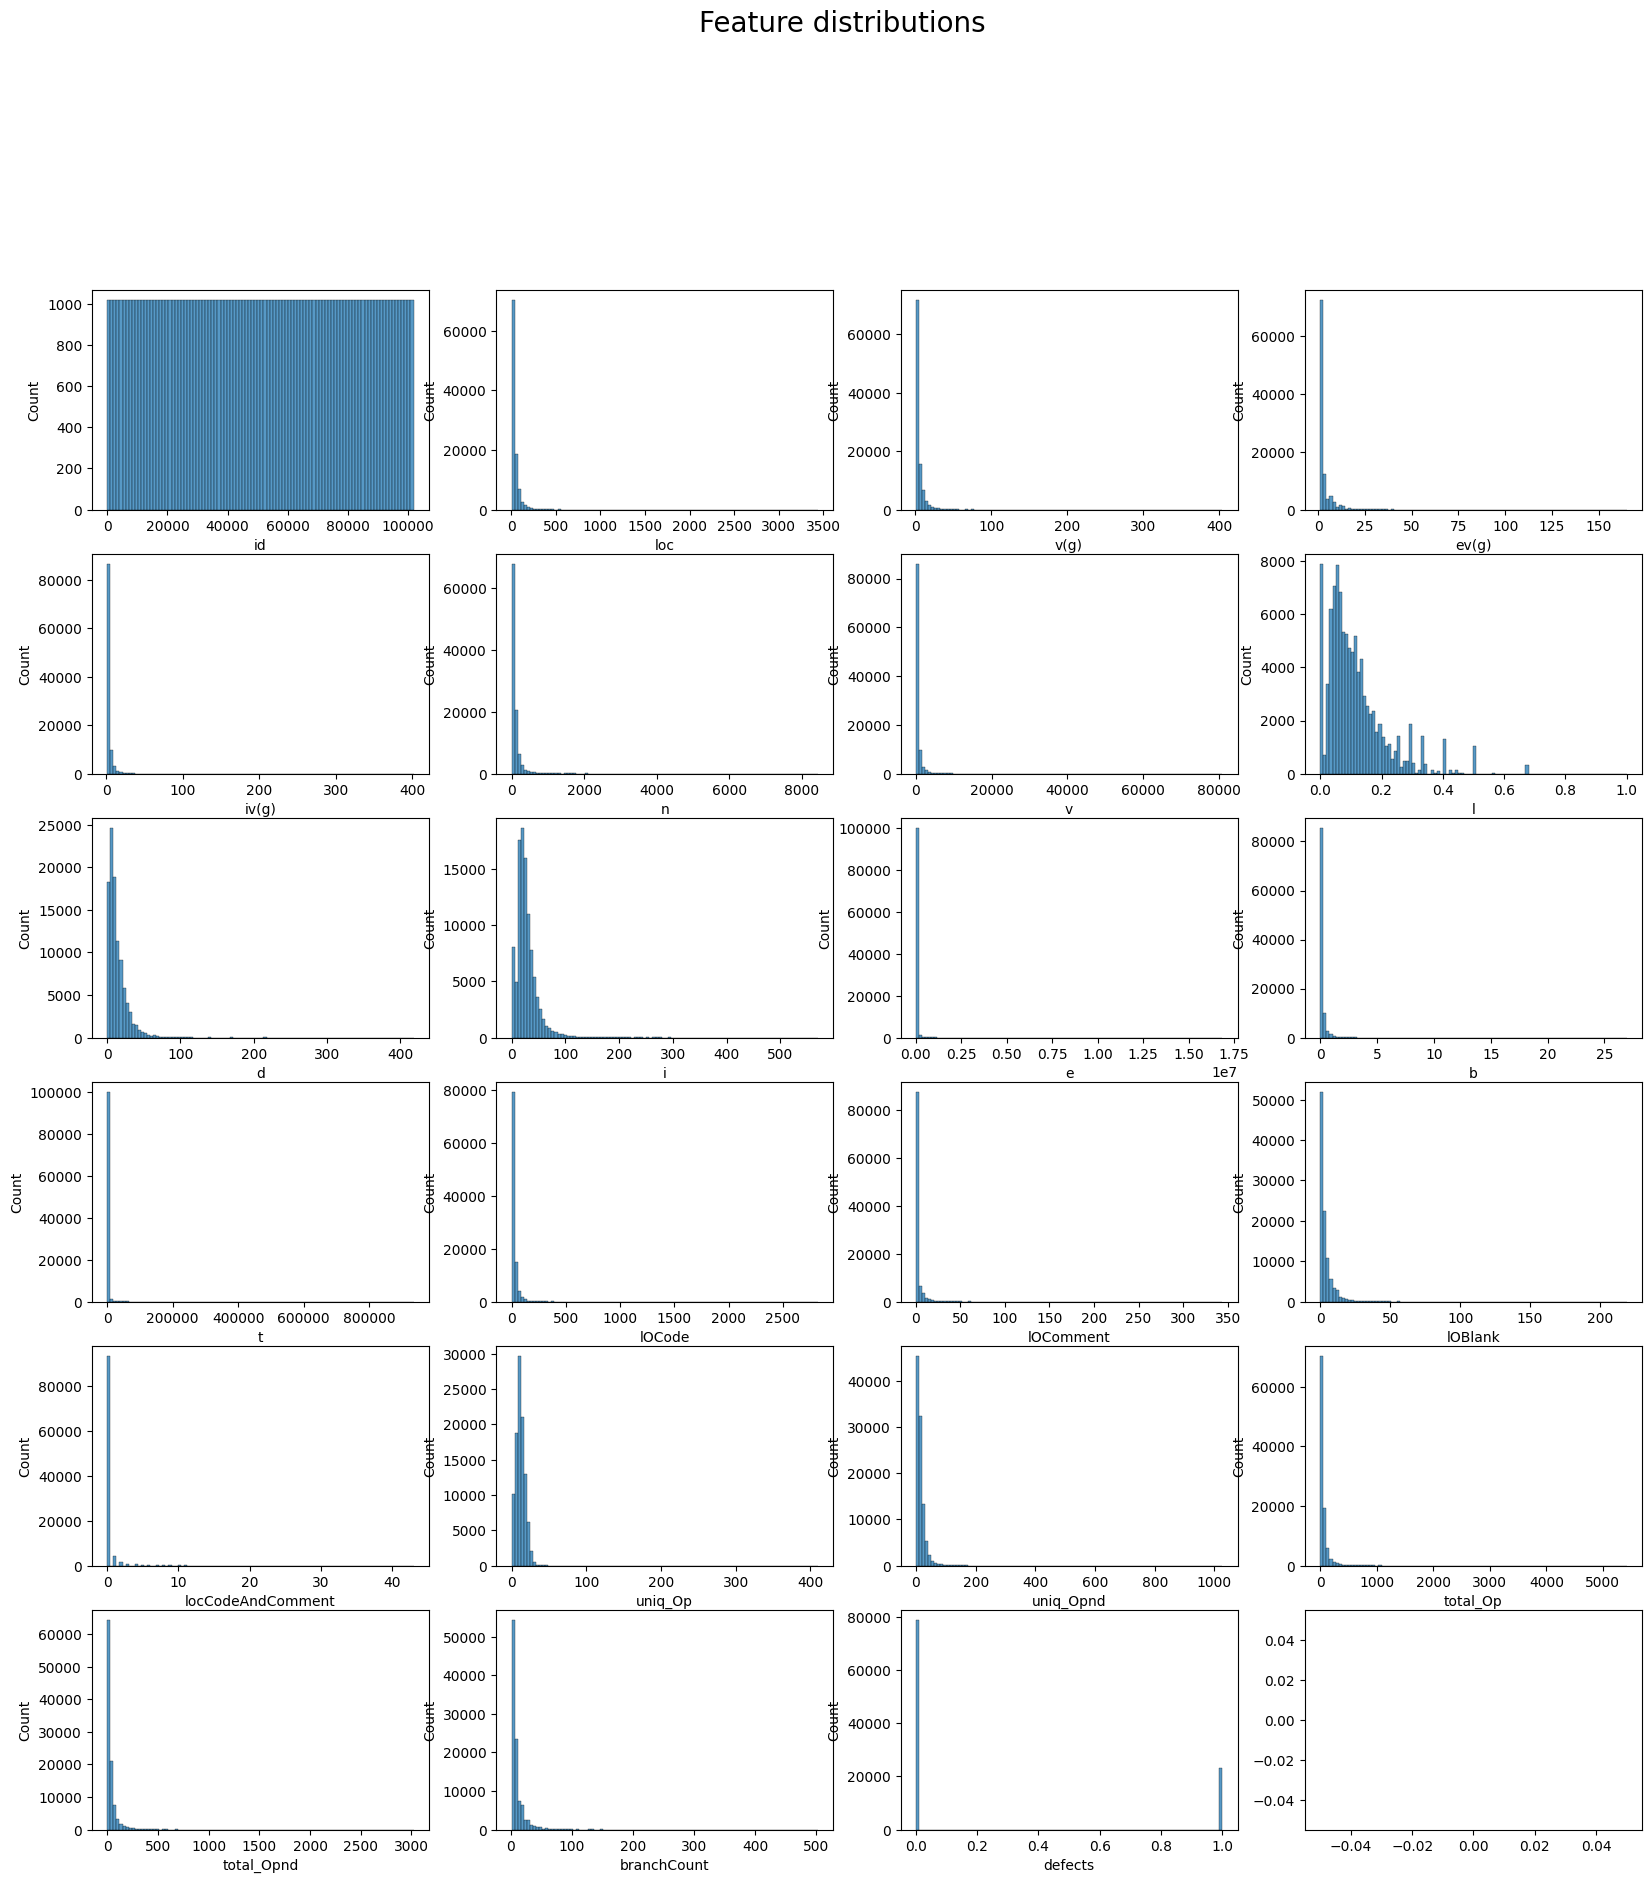

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution(data):
    rows = np.ceil(len(data.columns)/4).astype(int)
    fig, ax = plt.subplots(nrows = rows, ncols = 4, figsize = (20,20))
    for i, col in enumerate(data.columns):
        sns.histplot(data,x=col,ax=ax[int(i/4)][i%4],bins=100)
    plt.suptitle('Feature distributions', y=1.02, fontsize=20)
    plt.plot()

plot_distribution(train_df)

**Majority of the features are left skewed**

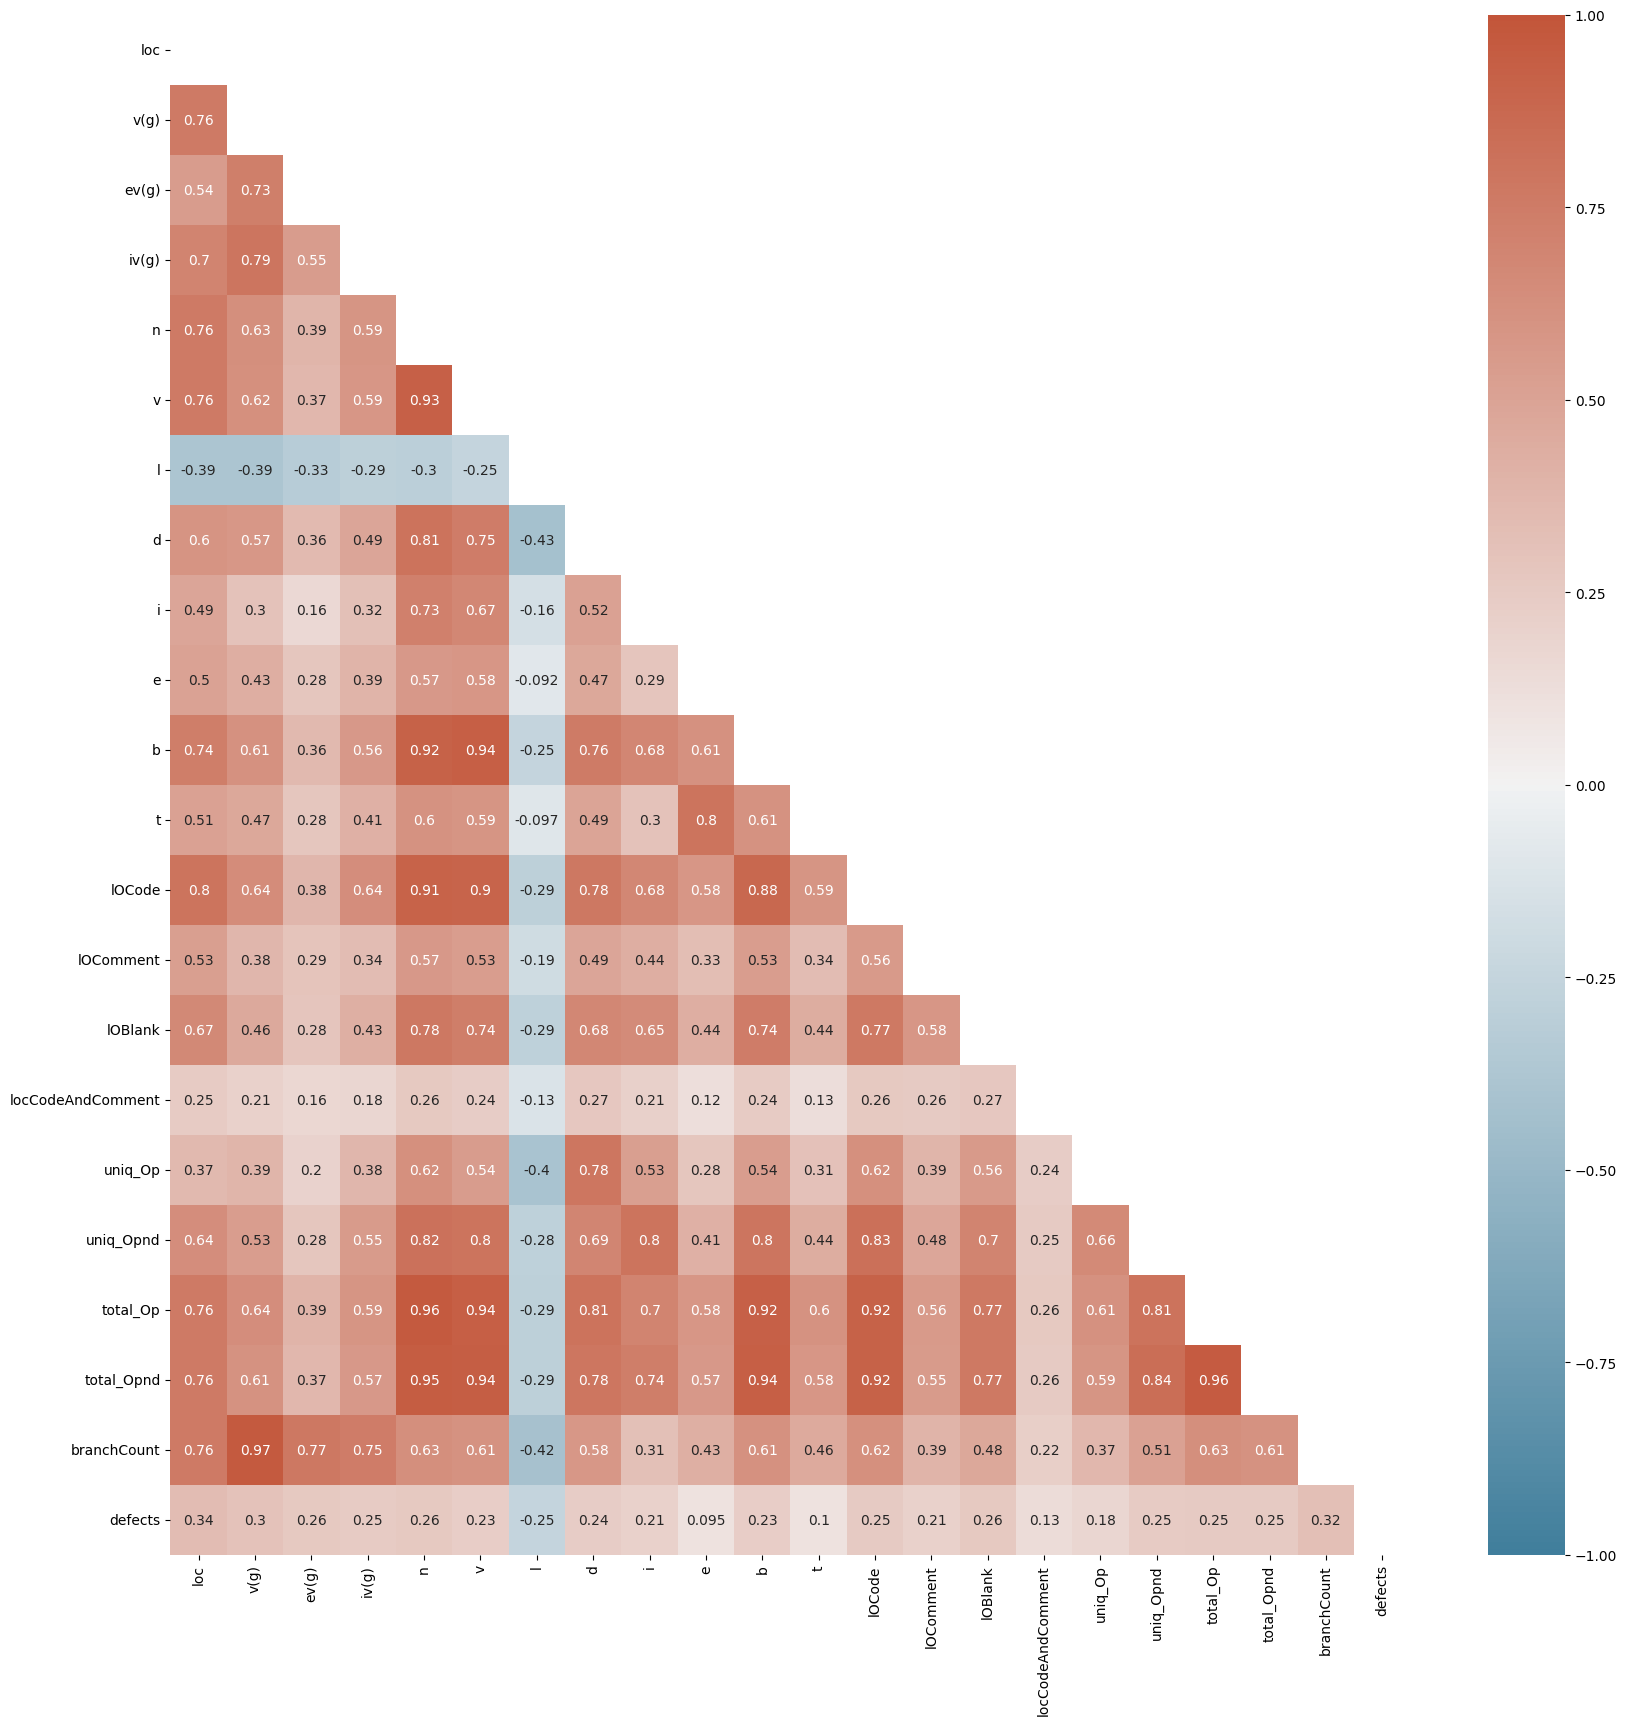

In [4]:
def plot_cor(data):
    if 'id' in data.columns:
        data = data.drop(['id'],axis=1)
    cor = data.corr()
    mask = np.triu(np.ones_like(cor,dtype = bool))
    cmap = sns.diverging_palette(230,20,as_cmap= True)
    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(cor,vmin= -1,vmax = 1,center=0,cmap=cmap,mask=mask,annot=True,)

plot_cor(train_df)

**Data is highly correlated**

In [5]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.model_selection import cross_val_score
from  sklearn.svm import LinearSVR

In [6]:
trans = FunctionTransformer(np.log1p)
trans_train = trans.fit_transform(train_df.drop(['id','defects'],axis=1))
scale = StandardScaler()
norm_train = pd.DataFrame(scale.fit_transform(trans_train))
pca = PCA(n_components = 12)
pca_train = pd.DataFrame(pca.fit_transform(norm_train))

In [7]:
model_log = LogisticRegression(l1_ratio=0.2,max_iter=150,)

score = cross_val_score(model_log,pca_train,train_df['defects'].astype(int))
print(score)

model_NB = GaussianNB()
score = cross_val_score(model_NB,pca_train,train_df['defects'].astype(int))
print(score)


[0.81182135 0.81196875 0.81172309 0.8099941  0.81289308]
[0.77379256 0.77158159 0.77403823 0.76857311 0.76955582]


In [8]:
model_log.fit(pca_train,train_df['defects'])
#model_NB.fit(pca_train,train_df['defects'])

LogisticRegression(l1_ratio=0.2, max_iter=150)

In [9]:
pipeline = make_pipeline(FunctionTransformer(np.log1p),StandardScaler(),PCA(n_components = 12))
test_norm = pd.DataFrame(pipeline.fit_transform(test_df.drop(['id'],axis=1)))

log_pred = pd.DataFrame(model_log.predict_proba(test_norm))
#nb_pred = pd.DataFrame(model_NB.predict_proba(test_norm))


In [10]:
final_pred = log_pred[1]
final_pred.columns = ['log']
#final_pred = final_pred[['log','NB']].apply(np.mean, axis = 1)


In [11]:
submission = pd.concat([test_df['id'],final_pred],axis=1)
submission.columns = ['id','defects']
submission.to_csv('submission.csv',index = False)
